# Problem A: 1D Elastostatics
Consider a rod made of linearly elastic material subjected to some load. Static problems will be considered here, by which is meant it is not necessary to know how the load was applied, or how the material particles moved to reach the stressed state; it is
necessary only that the load is applied slowly enough so that the accelerations are zero, or that it was applied sufficiently long ago that any vibrations have died away and movement has ceased. 

The equations governing the static response of the rod are: 
$$
-\frac{d}{dx} \left( E(x) \frac{du}{dx} \right) = f, \quad x \in (0, L) \tag{1}
$$
where
- $u(x):$ displacement field of the rod
- $E(x):$ Young’s modulus 
- $f=9.81:$ body force per unit length (e.g., gravity)
- $L=1.:$ Length of the rod

We consider the fixation of both sides of the rod, which leads to the following boundary conditions:
- $u(0) = u(L) = 0$

## Task 2: Recover the Young's modulus $E(x)$ from the observation of displacement field $u(x)$
In this task, the Young's modulus $E(x)>0$ of the rod is unknown. However, we observe the displacement field $u_{obs}$ (contaminated by noise with noise level $\sim 5\%$) on a set of randomly placed sensors $x_{obs}$ (with size $N_{obs}=250$). Moreover, we are able to measure the Young's modulus of the rod at two boundary sides, i.e., $E(0)=E(1)=1$.

### The goals
- Please select a suitable deep learning method for solving this inverse problem to recover the Young's modulus $E(x)$, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $e_{pred} (or\ u_{pred})$ and the truth $e_{true} (or\ u_{true})$ is defined as follows:
  $$error = \sqrt{\frac{\sum^{n}_i|e_{pred}(x_i)-e_{true}(x_i)|^2}{\sum^{n}_{i}|e_{true}(x_i)|^2}}$$
- Plot the predicted solution (and the ground truth reference) and the pointwise absolute error using separate figures with ```matplotlib```.
  
### Dataset
The observation and the ground truth references are given in the dataset ```LinearElasticity1d_inverse.h5```:
- ```x_obs```: the observation sensors 
- ```u_obs```: the observed displacement field $u$ (contaminated by noie)
- ```x_test```: the locations where the ground truth is evaluated (Should not be used for training)
- ```e_test```: the ground truth reference for Young's modulus (Should not be used for training)
- ```u_test```: the ground truth reference for displacement field (Should not be used for training)
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde](https://www.kaggle.com/datasets/yhzang32/physicsinformedlearning4pde)

### Importing necessary libraries

In [ ]:
import numpy as np
import os
import h5py
import torch 
import torch.nn as nn
from tqdm import trange
import matplotlib.pyplot as plt
from torch.autograd import grad, Variable
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(1234)

current_workspace = os.getcwd()
device = 'cpu'
dtype = torch.float32

<KeysViewHDF5 ['e_test', 'u_obs', 'u_test', 'x_obs', 'x_test']>


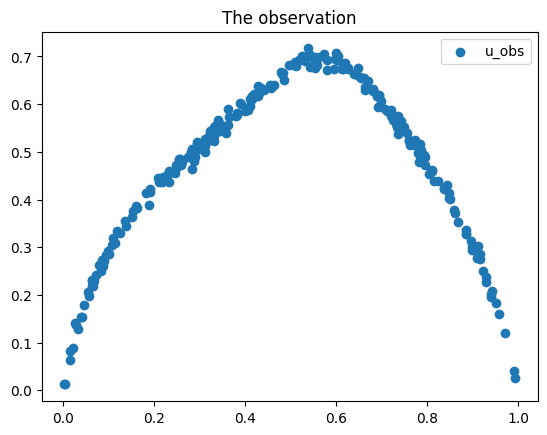

In [ ]:
with h5py.File('Datasets/LinearElasticity1d_inverse.h5', 'r') as file:
    x_obs = np.array(file['x_obs']).reshape(-1,1)
    u_obs = np.array(file['u_obs']).reshape(-1,1)
    x_test = np.array(file['x_test']).reshape(-1,1)
    e_test = np.array(file['e_test']).reshape(-1,1)
    u_test = np.array(file['u_test']).reshape(-1,1)
    
plt.figure()
plt.scatter(x_obs, u_obs, label='u_obs')
plt.title('The observation')
plt.legend()
plt.show()

x_obs = torch.tensor(x_obs, dtype=dtype)
u_obs = torch.tensor(u_obs, dtype=dtype)
x_test = torch.tensor(x_test, dtype=dtype)
e_test = torch.tensor(e_test, dtype=dtype)
u_test = torch.tensor(u_test, dtype=dtype)


In [ ]:
class MyDataset(Dataset):

    def __init__(self, x):
        self.x = x.reshape(-1, 1)

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

### Building the architecture of the NN

In [ ]:
class MLP(nn.Module):

    def __init__(self, layers_list:list, dtype=None):
        super(MLP, self).__init__()
        # Network Sequential
        net = []
        self.hidden_in = layers_list[0]
        for hidden in layers_list[1:]:
            net.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in = hidden
        self.net = nn.Sequential(*net)

    def activation(self, x):
        '''Self-defined activation'''
        x = torch.tanh(x)
        x = torch.sin(torch.pi*x+torch.pi)
        return x
        
    def forward(self, x):
        # Input and hidden layers
        for net in self.net[:-1]:
            x = net(x)
            x = self.activation(x)
        # Output layer
        x = self.net[-1](x)

        return torch.nn.functional.silu(x)
####################################################

### Defining the loss class of the PINN

In [6]:
class Mollifier(object):
    '''For capturing the zero boundary condition'''

    def __init__(self, dim):
        self.dim = dim

    def apply(self, u, x):
            return torch.sin(torch.pi * x) * u

class LossClass(object):

    def __init__(self, u_model, e_model):
        self.device = device
        self.u_model = u_model 
        self.e_model = e_model
        self.getLoss = torch.nn.MSELoss()
        #
        self.mollifier = Mollifier(1)
    
    def loss_pde(self, x_in):
        '''loss term related to the PDE'''
        # return torch.tensor(0.)
        ################# The PDE loss
        x = Variable(x_in, requires_grad=True).to(self.device)
        #
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)
        du_dx = grad(inputs=x, outputs=u, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        ex = self.e_model(x)
        #
        s = ex * du_dx
        ds_dx = grad(inputs=x, outputs=s, grad_outputs=torch.ones_like(s), create_graph=True)[0]

        # f(x)
        f = 9.81

        # The residuals
        residual = - ds_dx - f
        ###########################################
        loss = self.getLoss(residual, torch.zeros_like(residual))
        
        return loss

    def loss_data(self, x_obs, u_obs):
        '''loss term corresponds to the observation'''
        x = x_obs.to(self.device)
        u = self.u_model(x)
        u = self.mollifier.apply(u, x)
        #
        loss = self.getLoss(u, u_obs.to(self.device))
        
        return loss

    def loss_e_boundary(self):
        x_bc = torch.tensor([[0.0], [1.0]], dtype=torch.float32).to(self.device)
        e_bc = torch.tensor([[1.0], [1.0]], dtype=torch.float32).to(self.device)
        e_pred = self.e_model(x_bc)
        return self.getLoss(e_pred, e_bc)
    
    def get_error_u(self, x_test, u_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        u_test = u_test.to(self.device)
        u = self.u_model(x_test)
        u = self.mollifier.apply(u, x_test)
        
        return torch.sqrt(torch.sum((u-u_test)**2)/torch.sum(u_test**2))
        
    def get_error_e(self, x_test, e_test):
        '''Compute the L^2 relative error when the testing dataset is given'''
        x_test = x_test.to(self.device)
        e_test = e_test.to(self.device)
        e = self.e_model(x_test)
        
        return torch.sqrt(torch.sum((e-e_test)**2)/torch.sum(e_test**2))


In [8]:
lb, ub = np.array([0.]), np.array([1.])
#
nc = 200000
x_in = np.random.uniform(lb, ub, nc)
x_in = torch.tensor(x_in, dtype=dtype)
    
dataloader = DataLoader(MyDataset(x_in), batch_size=1000, shuffle=True)

epochs = 800
lr = 3e-3
model_u = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
model_e = MLP([1, 40, 40, 40, 40, 1], dtype=torch.float32).to(device)
optimizer = torch.optim.Adam(params=list(model_u.parameters())+list(model_e.parameters()), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/8), gamma=0.5)

w_pde = 2.
w_data = 200.
w_bc_e = 100.

loss_list, error_u_list, error_e_list = [],  [], []
for epoch in trange(epochs):
    loss = 0.
    for x_batch in dataloader:
        lossClass = LossClass(model_u, model_e)
        ############# Calculate losses
        loss_pde = lossClass.loss_pde(x_batch)
        loss_data = lossClass.loss_data(x_obs, u_obs)
        loss_e_bc = lossClass.loss_e_boundary()

        loss_train = w_pde * loss_pde + w_data * loss_data + w_bc_e * loss_e_bc
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        loss += loss_train

    # save loss
    loss = loss/len(dataloader)
    loss_list.append(loss.item())
    
    # compute error
    with torch.no_grad():
        error_u = lossClass.get_error_u(x_test, u_test)
        error_u_list.append(error_u.item())
        error_e = lossClass.get_error_e(x_test, e_test)
        error_e_list.append(error_e.item())
    scheduler.step()  # Adjust learning rate
    #
    if (epoch+1)%25==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()}, lr: {scheduler.optimizer.param_groups[0]["lr"]}')
        print(error_u_list.pop(), error_e_list.pop())

  3%|▎         | 25/800 [01:15<40:06,  3.11s/it]

Epoch:24, The loss is:159.34727478027344, lr: 0.003
0.28085586428642273 0.8242447376251221


  6%|▋         | 50/800 [02:56<54:14,  4.34s/it]

Epoch:49, The loss is:159.57032775878906, lr: 0.003
0.28051790595054626 0.8379945158958435


  9%|▉         | 75/800 [04:46<48:58,  4.05s/it]  

Epoch:74, The loss is:159.3361053466797, lr: 0.003
0.2805146276950836 0.8299841284751892


 12%|█▎        | 100/800 [06:21<48:09,  4.13s/it]

Epoch:99, The loss is:159.0048370361328, lr: 0.0015
0.28051134943962097 0.8251486420631409


 16%|█▌        | 125/800 [08:04<47:48,  4.25s/it]

Epoch:124, The loss is:159.09713745117188, lr: 0.0015
0.28051328659057617 0.8231567144393921


 18%|█▊        | 148/800 [09:40<42:35,  3.92s/it]


KeyboardInterrupt: 

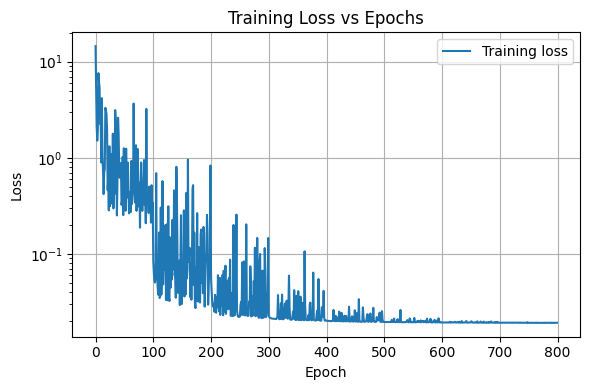

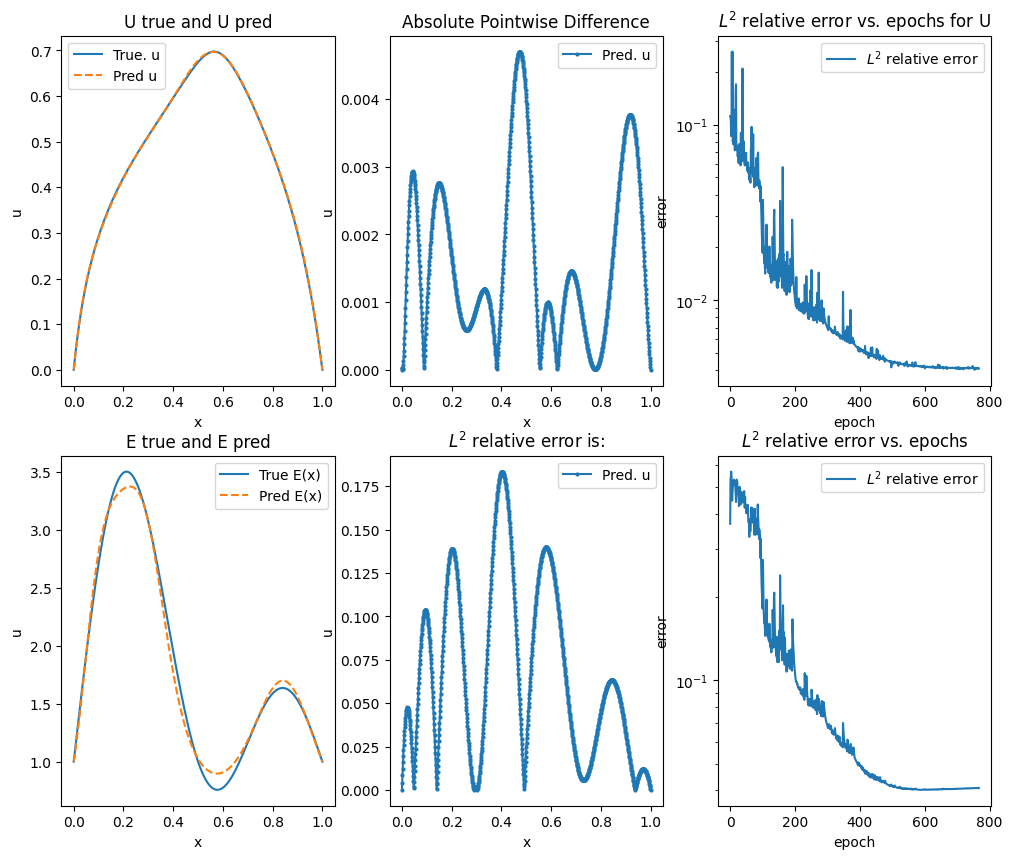

In [ ]:
####### Make prediction with the trained model
x_query = x_test
# The prediction
u_query = model_u(x_query.to(device)).detach()
u_query = Mollifier(1).apply(u_query, x_query)
e_query = model_e(x_query.to(device)).detach()

plt.figure(figsize=(6, 4))
plt.semilogy(loss_list, label='Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,10))
axes[0][0].plot(x_test.numpy().squeeze(), u_test.numpy().squeeze(), label='True. u')
axes[0][0].plot(x_test.numpy().squeeze(), u_query.numpy().squeeze(),linestyle='--', label='Pred u')
axes[0][0].set_title(f'U true and U pred')
axes[0][0].set_xlabel('x')
axes[0][0].set_ylabel('u')
axes[0][0].legend()

axes[0][1].plot(x_test, np.abs(u_query.numpy().squeeze()-u_test.numpy().squeeze()), marker='o', markersize=2, label='Pred. u')
axes[0][1].set_title(f'Absolute Pointwise Difference')
axes[0][1].set_xlabel('x')
axes[0][1].set_ylabel('u')
axes[0][1].legend()
axes[0][2].semilogy(error_u_list, label='$L^2$ relative error')
axes[0][2].set_title('$L^2$ relative error vs. epochs for U')
axes[0][2].set_xlabel('epoch')
axes[0][2].set_ylabel('error')
axes[0][2].legend()

axes[1][0].plot(x_test.numpy().squeeze(), e_test.numpy().squeeze(),label='True E(x)')
axes[1][0].plot(x_test.numpy().squeeze(), e_query.numpy().squeeze(),  linestyle='--', label='Pred E(x)')
axes[1][0].set_title(f'E true and E pred')
axes[1][0].set_xlabel('x')
axes[1][0].set_ylabel('u')
axes[1][0].legend()

axes[1][1].plot(x_test, np.abs(e_query.numpy().squeeze()-e_test.numpy().squeeze()), marker='o', markersize=2, label='Pred. u')
axes[1][1].set_title(f'$L^2$ relative error is:')
axes[1][1].set_xlabel('x')
axes[1][1].set_ylabel('u')
axes[1][1].legend()

axes[1][2].semilogy(error_e_list, label='$L^2$ relative error')
axes[1][2].set_title('$L^2$ relative error vs. epochs')
axes[1][2].set_xlabel('epoch')
axes[1][2].set_ylabel('error')
axes[1][2].legend()
plt.show()

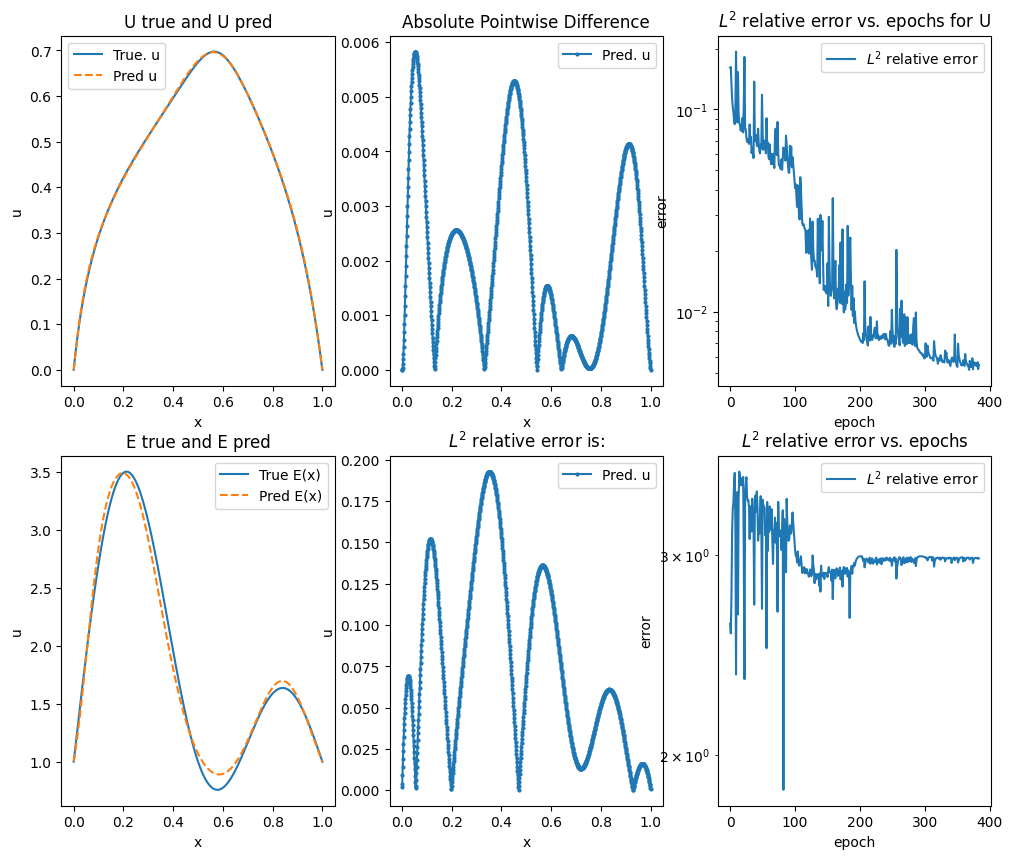